# Solving Navier-Stokes with a stationary body

In [1]:
using ViscousFlow

┌ Info: Precompiling ViscousFlow [103da179-b3e4-57c1-99a4-586354eb2c5a]
└ @ Base loading.jl:1260


In [2]:
using Plots
pyplot()
default(grid = false)

Set the flow parameters

In [3]:
Re = 100; # Reynolds number
U = 1.0; # Free stream velocity
U∞ = (U,0.0);

Set up the domain, grid spacing, and time step size

In [4]:
xlim = (-2.0,3.0)
ylim = (-2.0,2.0)

Δx, Δt = setstepsizes(Re,gridRe=2.0)

(0.02, 0.01)

#### Set up points on the body. We set the points so that the spacing between them is 1.5 times the grid spacing.

Here is a plate:

In [4]:
body = Plate(1.0,1.5Δx)

Plate with 66 points and length 1.0 and thickness 0.0
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


In [5]:
body = Circle(1.0,1.5Δx)

Circular body with 209 points and radius 1.0
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


or here is a NACA 0012 airfoil

In [6]:
#body = NACA4(0.0,0.0,0.12,1.5Δx)

#### Transform the body to a specified initial position and orientation.

In [6]:
cent = (0.0,0.0)
α = 0.0 #40π/180 #π/3 #π/4
T = RigidTransform(cent,-α)
T(body) # transform the body to the current configuration

Circular body with 209 points and radius 1.0
   Current position: (0.0,0.0)
   Current angle (rad): -0.0


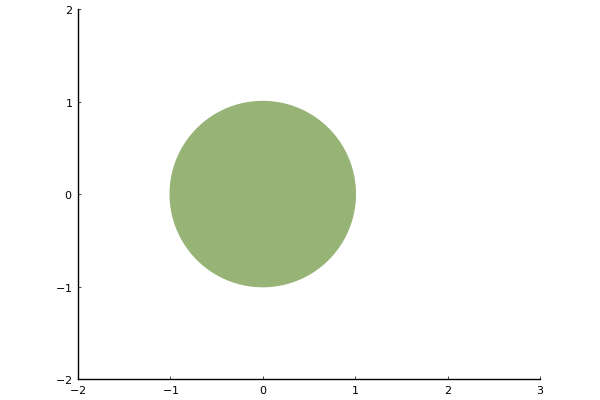

In [7]:
plot(body,xlim=xlim,ylim=ylim)

Collect the body point data into a vector

In [6]:
X = VectorData(collect(body));

### Now set up the system

Set up the system operators

In [8]:
sys = NavierStokes(Re,Δx,xlim,ylim,Δt,body,freestream = U∞)

External/internal Navier-Stokes system on a grid of size 252 x 208 and 209 static immersed points
   Static freestream = (1.0, 0.0)
   1 body


Initial conditions, and grid coordinates

In [9]:
w₀ = Nodes(Dual,size(sys));
f = VectorData(sys.points);
xg, yg = coordinates(w₀,sys.grid)

(-2.0100000000000002:0.02:3.0100000000000002, -2.07:0.02:2.07)

Set up the integrator here

In [10]:
plan_intfact(t,u) = CartesianGrids.plan_intfact(t,u,sys)
plan_constraints(u,t) = ConstrainedSystems.plan_constraints(u,t,sys)
r₁(u,t) = ConstrainedSystems.r₁(u,t,sys)
r₂(u,t) = ConstrainedSystems.r₂(u,t,sys)


@time solver = IFHERK(w₀,f,timestep(sys),plan_intfact,plan_constraints,(r₁,r₂),rk=ConstrainedSystems.RK31)

 13.713240 seconds (22.69 M allocations: 5.207 GiB, 6.28% gc time)


Order-3 IF-HERK integrator with
   State of type Nodes{Dual,252,208,Float64,Array{Float64,2}}
   Force of type VectorData{209,Float64,Array{Float64,1}}
   Time step size 0.01


Initialize the state vector and the history vectors

In [11]:
t = 0.0
u = zero(w₀)

# Rate at which to store field data
tsample = 0.2

# Field data storage plan
S = StorePlan(tsample,"state"=>u,"time"=>t)
data_history = initialize_storage(S)

# Force data storage plan, stored every time step
F = StorePlan(timestep(sys),"fx"=>sum(f.u),"fy"=>sum(f.v),"time"=>t)
force_history = initialize_storage(F)
nothing

### Advance the system!

Set the length of time to integrate over.

In [12]:
tsim = 1.0;

In [13]:
@time for ti in timerange(tsim,sys)
    global t, u, f = solver(t,u)
    
    fds = force(f,sys) 
    
    store_data!(data_history,t,S,"state" => u, "time" => t)
    store_data!(force_history,t,F,"fx" => sum(fds.u),"fy" => sum(fds.v),"time" => t)
    
 end
println("solution completed through time t = ",t)

 11.833104 seconds (16.82 M allocations: 4.738 GiB, 5.79% gc time)
solution completed through time t = 1.0000000000000007


#### Plotting

Basic plot

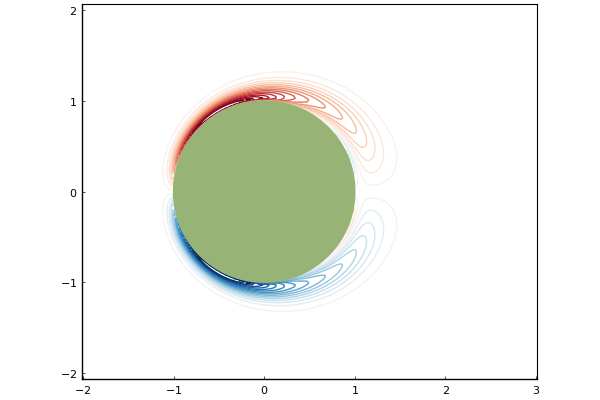

In [15]:
plot(xg,yg,vorticity(data_history["state"][end],sys,0.0),levels=range(-15,15,length=30), color = :RdBu,clim=(-15,15))
plot!(body)

Streamlines

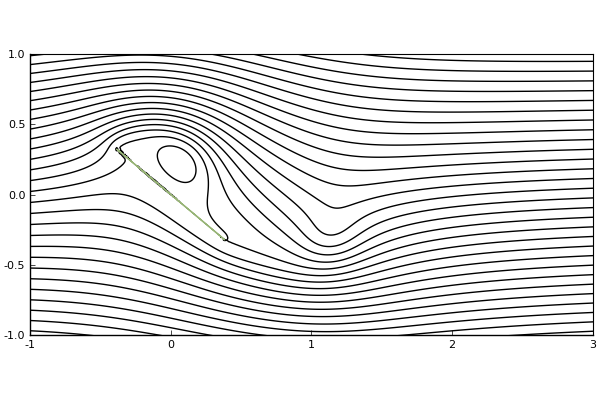

In [51]:
plot(xg,yg,streamfunction(data_history["state"][end],sys),levels=range(-1,1,length=31), color = :black,clim=(-0.25,0.25),xlim=(-1,3),ylim=(-1,1))
plot!(body)

Plot lift and drag coefficient

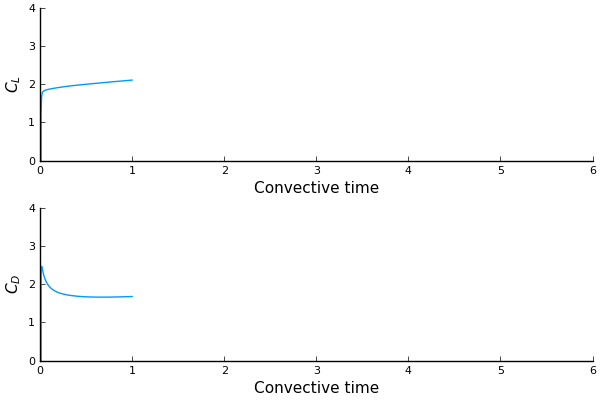

In [50]:
plt = plot(layout = (2,1), size = (600, 400))
plot!(plt[1],force_history["time"],2*force_history["fy"],xlim=(0,6),ylim=(0,4),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot!(plt[2],force_history["time"],2*force_history["fx"],xlim=(0,6),ylim=(0,4),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
plt